## 2. Load Data and Train a model then save the model's weight

**Used Hyperparameter**<br>
Without Data Augmentation<br>


-----------------------<br>
Level: 1,2 images <br>
Number of train,val,test: 9
, 3, 3 <br>
train's stride : 299 <br>
test's stride: 299 <br>
tissue percent min: 50 <br>


In [1]:
import numpy as np
import os
from PIL import Image
import pathlib
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from itertools import chain
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from matplotlib.patches import Rectangle
import re
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [2]:
import os

# Initialization
lowest_level = 1
highest_level = 2
train_val_stride = 299
test_stride = 299
tissue_p_min = 50

dir = '/content/drive/MyDrive/Applied_Deep_Learning_Project/'
current_dir = 'Lev_12_split_933_stride_299_pmin_50'
saving_dir = os.path.join(dir,current_dir)
saving_dir

'/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_12_split_933_stride_299_pmin_50'

In [3]:
# Mount drive
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)
print()

# Check TensorFlow version
import tensorflow as tf 
print("TF version: ", tf.__version__)
print()

# Check which GPU with available RAM
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

Mounted at /content/drive

TF version:  2.4.0

Found GPU at: /device:GPU:0
name, driver_version, memory.total [MiB]
Tesla V100-SXM2-16GB, 418.67, 16130 MiB


In [19]:
zoom1_train = np.load(os.path.join(saving_dir,'zoom1_train.npy'))
zoom2_train = np.load(os.path.join(saving_dir,'zoom2_train.npy'))
label_train = np.load(os.path.join(saving_dir,'label_train.npy'))

zoom1_valid = np.load(os.path.join(saving_dir,'zoom1_valid.npy'))
zoom2_valid = np.load(os.path.join(saving_dir,'zoom2_valid.npy'))
label_valid = np.load(os.path.join(saving_dir,'label_valid.npy'))

X_train = [zoom1_train, zoom2_train]
X_valid = [zoom1_valid, zoom2_valid]
BATCH_SIZE = 32

In [5]:
def create_inceptionv3(weights='imagenet',include_top = False, input_shape = (299,299,3)):
  base_model = tf.keras.applications.InceptionV3(weights=weights,include_top = include_top, input_shape = input_shape)
  base_model.trainable = False
  return base_model


def create_inceptionv3_fine_tune(weights='imagenet',include_top = False, input_shape = (299,299,3)):
  base_model = tf.keras.applications.InceptionV3(weights=weights,include_top = include_top, input_shape = input_shape)
  
  base_model.trainable = True
  # Let's take a look to see how many layers are in the base model
  print("Number of layers in the base InceptionV3 model: ", len(base_model.layers))
  # Fine-tune from this layer onwards
  fine_tune_at = 100
  print("Start fine tuning at layer: ", fine_tune_at)

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

  return base_model


def create_global_avg_layer():
  return tf.keras.layers.GlobalAveragePooling2D()


def create_dense_layer():
  return tf.keras.layers.Dense(1024, activation='relu')

In [6]:
# Reference used to put multiple inputs
# # https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

def create_model_keras_inputs_two(fine_tune):

  if fine_tune:
    base_model_1 = create_inceptionv3_fine_tune()
    base_model_2 = create_inceptionv3_fine_tune()
  
  else: 
    base_model_1 = create_inceptionv3()
    base_model_2 = create_inceptionv3()

  global_avg_layer = create_global_avg_layer()
  dense_layer = create_dense_layer()

  model_1 = tf.keras.Sequential([
    base_model_1,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  model_2 = tf.keras.Sequential([
    base_model_2,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  input1 = Input(shape=(299,299,3))
  input2 = Input(shape=(299,299,3))
    
  model_concat = concatenate([model_1(input1) ,model_2(input2)])
  model = Dense(1024, activation='relu')(model_concat)
  model = Dense(1, activation='sigmoid')(model)
  model_final = Model(inputs=[input1,input2],outputs=model)

  return model_final

In [7]:
# A plotting function you can reuse
def plot(history):
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  # added new version for better layout in visualization (for fun)
  fig, ax = plt.subplots(1,2, figsize = (14,5))
  ax[0].set_title('Training and validation accuracy')
  ax[0].plot(epochs, acc, color='blue', label='Train')
  ax[0].plot(epochs, val_acc, color='orange', label='Val')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()

  ax[1].set_title('Training and validation loss')
  ax[1].plot(epochs, loss, color='blue', label='Train')
  ax[1].plot(epochs, val_loss, color='orange', label='Val')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()

### Version a: <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         23900960    input_3[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1024)         23900960    input_4[0][0]                    
_____________________________

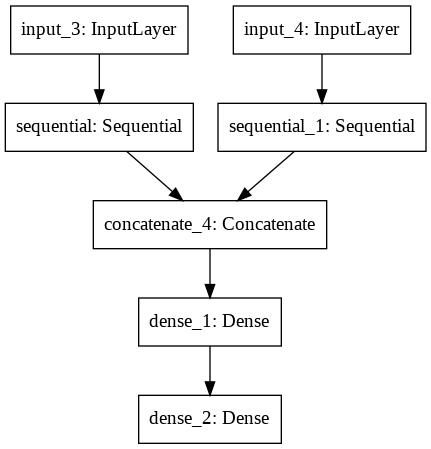

In [11]:
mdl_9_3_wo_ft_wo_da = create_model_keras_inputs_two(fine_tune = False)
mdl_9_3_wo_ft_wo_da.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da))

Epoch 1/10
299/299 [==============================] - 60s 164ms/step - loss: 6.5936 - accuracy: 0.8144 - val_loss: 1.3944 - val_accuracy: 0.5928
Epoch 2/10
299/299 [==============================] - 46s 154ms/step - loss: 0.2765 - accuracy: 0.8938 - val_loss: 0.9555 - val_accuracy: 0.6193
Epoch 3/10
299/299 [==============================] - 46s 154ms/step - loss: 0.2403 - accuracy: 0.9099 - val_loss: 1.3251 - val_accuracy: 0.5928
Epoch 4/10
299/299 [==============================] - 46s 154ms/step - loss: 0.2514 - accuracy: 0.9017 - val_loss: 0.6743 - val_accuracy: 0.6759
Epoch 5/10
299/299 [==============================] - 46s 154ms/step - loss: 0.2222 - accuracy: 0.9189 - val_loss: 1.2679 - val_accuracy: 0.5867
Epoch 6/10
299/299 [==============================] - 46s 154ms/step - loss: 0.2049 - accuracy: 0.9197 - val_loss: 1.0964 - val_accuracy: 0.6301
Epoch 7/10
299/299 [==============================] - 46s 153ms/step - loss: 0.1998 - accuracy: 0.9214 - val_loss: 2.2292 - val_ac

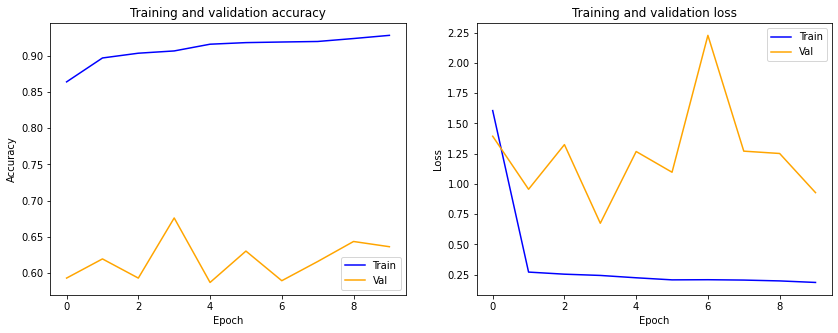

In [12]:
mdl_9_3_wo_ft_wo_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_wo_ft_wo_da.fit(X_train,label_train, batch_size=BATCH_SIZE,
                             validation_data =(X_valid, label_valid),  epochs=10))

In [13]:
#save_weights
mdl_9_3_wo_ft_wo_da.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da.h5/"))

del mdl_9_3_wo_ft_wo_da

### Version b: <br>
#### A model train with 9 train, 3 val [per image]
#### model **with** fine tuning and **without** data augmentation

In [14]:
mdl_9_3_w_ft_wo_da = create_model_keras_inputs_two(fine_tune = True)
mdl_9_3_w_ft_wo_da.summary()
# display(plot_model(mdl_9_3_w_ft_wo_da))

Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1024)         23900960    input_7[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Seque

Epoch 1/10
299/299 [==============================] - 108s 320ms/step - loss: 0.4096 - accuracy: 0.8551 - val_loss: 1.4633 - val_accuracy: 0.5193
Epoch 2/10
299/299 [==============================] - 93s 312ms/step - loss: 0.1767 - accuracy: 0.9361 - val_loss: 0.9960 - val_accuracy: 0.5241
Epoch 3/10
299/299 [==============================] - 93s 313ms/step - loss: 0.1429 - accuracy: 0.9495 - val_loss: 0.7427 - val_accuracy: 0.7783
Epoch 4/10
299/299 [==============================] - 94s 313ms/step - loss: 0.1374 - accuracy: 0.9550 - val_loss: 0.9290 - val_accuracy: 0.7361
Epoch 5/10
299/299 [==============================] - 93s 312ms/step - loss: 0.1121 - accuracy: 0.9592 - val_loss: 2.5243 - val_accuracy: 0.5988
Epoch 6/10
299/299 [==============================] - 94s 313ms/step - loss: 0.1170 - accuracy: 0.9569 - val_loss: 1.9619 - val_accuracy: 0.5639
Epoch 7/10
299/299 [==============================] - 93s 312ms/step - loss: 0.0959 - accuracy: 0.9638 - val_loss: 1.7837 - val_a

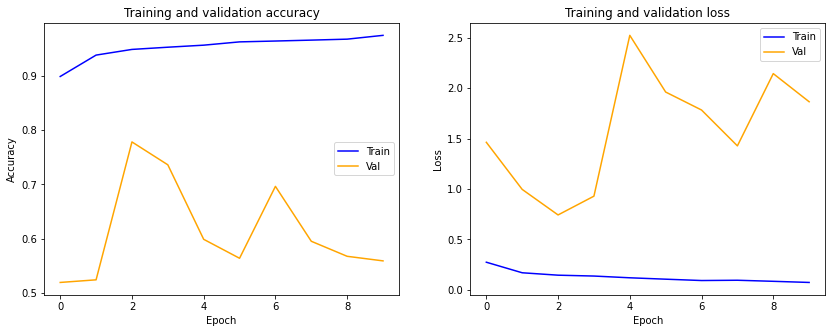

In [15]:
mdl_9_3_w_ft_wo_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_w_ft_wo_da.fit(X_train,label_train, batch_size=BATCH_SIZE, 
                             validation_data =(X_valid, label_valid),  epochs=10))

In [16]:
#save_weights
mdl_9_3_w_ft_wo_da.save_weights(os.path.join(saving_dir,"mdl_9_3_w_ft_wo_da.h5/"))

del mdl_9_3_w_ft_wo_da

### Version c: <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **with** data augmentation

In [10]:
# Reference used to take multiple inputs for ImageData Geneartor
# https://stackoverflow.com/questions/49404993/keras-how-to-use-fit-generator-with-multiple-inputs

gen = ImageDataGenerator(
    rotation_range=90,
    shear_range=0.2)
    # horizontal_flip = True,
    # vertical_flip = True)

gen_valid = ImageDataGenerator()

def generator_two_img(X1, X2, y, batch_size):
    genX1 = gen.flow(X1, y,  batch_size=batch_size, seed=1)
    genX2 = gen.flow(X2, y, batch_size=batch_size, seed=1)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X1i[1]

def generator_two_img_valid(X1, X2, y, batch_size):
    genX1 = gen_valid.flow(X1, y,  batch_size=batch_size, seed=1)
    genX2 = gen_valid.flow(X2, y, batch_size=batch_size, seed=1)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X1i[1]

X_train_ = generator_two_img(zoom1_train, zoom2_train, label_train, 32)
X_valid_ = generator_two_img_valid(zoom1_valid, zoom2_valid, label_valid, 32)
BATCH_SIZE = 32

In [11]:
mdl_9_3_wo_ft_w_da = create_model_keras_inputs_two(fine_tune = False)
mdl_9_3_wo_ft_w_da.summary()
# display(plot_model(mdl_9_3_wo_ft_w_da))

87916544/87910968 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         23900960    input_3[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1024)         23900960    input_4[0][0]                    
_____________________________

In [ ]:
mdl_9_3_wo_ft_w_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_wo_ft_w_da.fit(X_train_, batch_size=BATCH_SIZE, 
                            steps_per_epoch = len(zoom1_train)/BATCH_SIZE,
                            validation_data =X_valid_, validation_steps = len(zoom1_valid)/BATCH_SIZE,
                            shuffle=False, epochs=15))

In [ ]:
#save_weights
mdl_9_3_wo_ft_w_da.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_w_da.h5/"))

del mdl_9_3_wo_ft_w_da

### Version d: <br>
#### A model train with 9 train, 3 val [per image]
#### model **with** fine tuning and **with** data augmentation

In [ ]:
mdl_9_3_w_ft_w_da = create_model_keras_inputs_two(fine_tune = True)
mdl_9_3_w_ft_w_da.summary()
# display(plot_model(mdl_9_3_w_ft_w_da))

Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 1024)         23900960    input_15[0][0]                   
__________________________________________________________________________________________________
sequential_7 (Seque

Epoch 1/15
172/172 [==============================] - 189s 1s/step - loss: 0.5253 - accuracy: 0.7833 - val_loss: 2.4569 - val_accuracy: 0.4259
Epoch 2/15
172/172 [==============================] - 178s 1s/step - loss: 0.2366 - accuracy: 0.9195 - val_loss: 10.1804 - val_accuracy: 0.4966
Epoch 3/15
172/172 [==============================] - 178s 1s/step - loss: 0.1724 - accuracy: 0.9322 - val_loss: 3.3666 - val_accuracy: 0.4983
Epoch 4/15
172/172 [==============================] - 178s 1s/step - loss: 0.1551 - accuracy: 0.9448 - val_loss: 1.4231 - val_accuracy: 0.5500
Epoch 5/15
172/172 [==============================] - 177s 1s/step - loss: 0.1342 - accuracy: 0.9479 - val_loss: 3.9771 - val_accuracy: 0.4862
Epoch 6/15
172/172 [==============================] - 177s 1s/step - loss: 0.1675 - accuracy: 0.9496 - val_loss: 1.3661 - val_accuracy: 0.5603
Epoch 7/15
172/172 [==============================] - 178s 1s/step - loss: 0.1046 - accuracy: 0.9641 - val_loss: 1.9574 - val_accuracy: 0.546

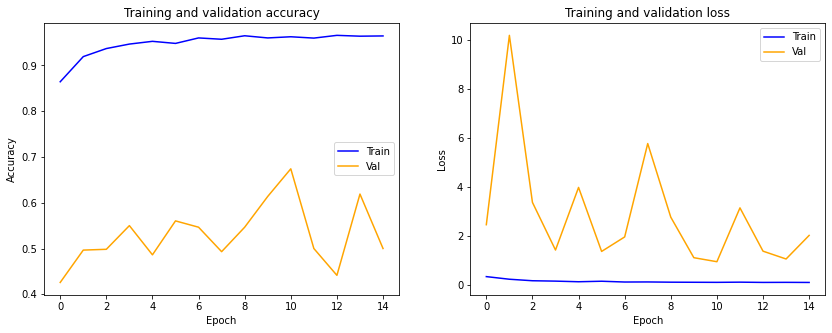

In [ ]:
mdl_9_3_w_ft_w_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_w_ft_w_da.fit(X_train_, batch_size=BATCH_SIZE, 
                steps_per_epoch = len(zoom1_train)/BATCH_SIZE,
                validation_data =X_valid_, validation_steps = len(zoom1_valid)/BATCH_SIZE, 
                shuffle=False, epochs=15))

In [ ]:
#save_weights
mdl_9_3_w_ft_w_da.save_weights(os.path.join(saving_dir,"mdl_9_3_w_ft_w_da.h5/"))

del mdl_9_3_w_ft_w_da

NameError: ignored

In [ ]:
# # Reference used to put multiple inputs
# # https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

# def create_model_keras_inputs_two_updated(fine_tune):

#   if fine_tune:
#     base_model_1 = create_inceptionv3_fine_tune()
#     base_model_2 = create_inceptionv3_fine_tune()
  
#   else: 
#     base_model_1 = create_inceptionv3()
#     base_model_2 = create_inceptionv3()

#   global_avg_layer = create_global_avg_layer()
#   dense_layer = create_dense_layer()
#   batch_norm_layer = create_batch_normalization()

#   model_1 = tf.keras.Sequential([
#     base_model_1,
#     global_avg_layer,
#     dense_layer,
#     #prediction_layer
#   ])

#   model_2 = tf.keras.Sequential([
#     base_model_2,
#     global_avg_layer,
#     dense_layer,
#     #prediction_layer
#   ])

#   input1 = Input(shape=(299,299,3))
#   input2 = Input(shape=(299,299,3))
    
#   model = concatenate([model_1(input1) ,model_2(input2)], axis =1)
  
#   model = tf.keras.layers.BatchNormalization()(model)
#   model = tf.keras.layers.Dropout(0.3)(model)
#   model = Dense(1024, activation='relu')(model)
  
#   model = tf.keras.layers.BatchNormalization()(model)
#   model = tf.keras.layers.Dropout(0.3)(model)
#   model = Dense(128, activation='relu')(model)
  
#   model = tf.keras.layers.BatchNormalization()(model)
#   model = tf.keras.layers.Dropout(0.3)(model)
#   model = Dense(1, activation='sigmoid')(model)

#   model_final = Model(inputs=[input1,input2],outputs=model)

#   return model_final

### Version 2.a: Batch Normalization <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation 
#### **Also** added Batch Normalization and extra dense layer

In [8]:
def add_layers(model, add_BN, add_Dropout):
  if add_BN:
    if add_Dropout:
      print("Added BN and Dropout")
      model = tf.keras.layers.BatchNormalization()(model)
      model = tf.keras.layers.Dropout(0.3)(model)
      model = Dense(1024, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = tf.keras.layers.Dropout(0.3)(model)
      model = Dense(128, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = tf.keras.layers.Dropout(0.3)(model)
      model = Dense(1, activation='sigmoid')(model)
      return model
    
    else: # i.e. only add Batch Normalization
      print("Added only BN")
      model = tf.keras.layers.BatchNormalization()(model)
      model = Dense(1024, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = Dense(128, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = Dense(1, activation='sigmoid')(model)
      return model

    
  else: # i.e. only apply Dropout
    print("Added only Dropout")
    model = tf.keras.layers.Dropout(0.3)(model)
    model = Dense(1024, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.3)(model)
    model = Dense(128, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.3)(model)
    model = Dense(1, activation='sigmoid')(model)
    return model

In [9]:
# Reference used to put multiple inputs
# https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

def create_model_keras_inputs_two_updated(fine_tune, add_BN, add_Dropout):

  if fine_tune:
    base_model_1 = create_inceptionv3_fine_tune()
    base_model_2 = create_inceptionv3_fine_tune()
  
  else: 
    base_model_1 = create_inceptionv3()
    base_model_2 = create_inceptionv3()

  global_avg_layer = create_global_avg_layer()
  dense_layer = create_dense_layer()

  model_1 = tf.keras.Sequential([
    base_model_1,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  model_2 = tf.keras.Sequential([
    base_model_2,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  input1 = Input(shape=(299,299,3))
  input2 = Input(shape=(299,299,3))
    
  model = concatenate([model_1(input1) ,model_2(input2)], axis =1)
  model = add_layers(model = model, add_BN = add_BN, add_Dropout = add_Dropout)
  model_final = Model(inputs=[input1,input2],outputs=model)

  return model_final

Added only BN
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         23900960    input_3[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1024)         23900960    input_4[0][0]                    
________________________________________________________________________________

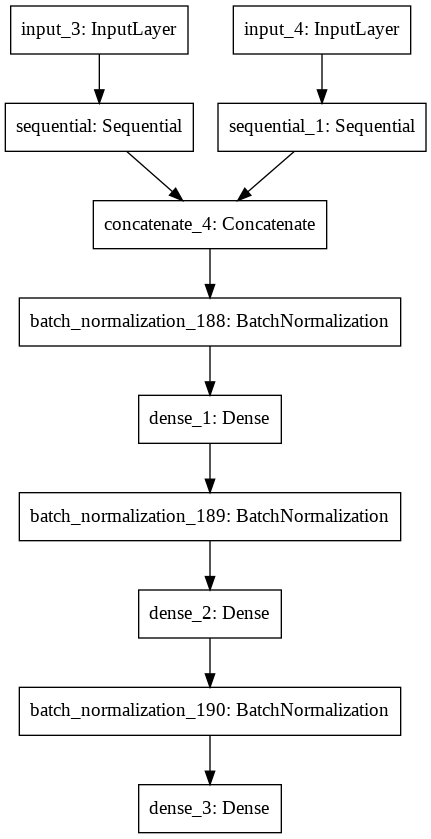

In [10]:
mdl_9_3_wo_ft_wo_da_BN = create_model_keras_inputs_two_updated(fine_tune = False, add_BN = True, add_Dropout = False)
mdl_9_3_wo_ft_wo_da_BN.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da_BN))

Epoch 1/10
299/299 [==============================] - 44s 100ms/step - loss: 0.3176 - accuracy: 0.8748 - val_loss: 0.9864 - val_accuracy: 0.6277
Epoch 2/10
299/299 [==============================] - 27s 89ms/step - loss: 0.2240 - accuracy: 0.9142 - val_loss: 1.0796 - val_accuracy: 0.6325
Epoch 3/10
299/299 [==============================] - 27s 90ms/step - loss: 0.1872 - accuracy: 0.9306 - val_loss: 1.7621 - val_accuracy: 0.5590
Epoch 4/10
299/299 [==============================] - 27s 89ms/step - loss: 0.1932 - accuracy: 0.9233 - val_loss: 1.3674 - val_accuracy: 0.5325
Epoch 5/10
299/299 [==============================] - 27s 89ms/step - loss: 0.1851 - accuracy: 0.9290 - val_loss: 1.2821 - val_accuracy: 0.5627
Epoch 6/10
299/299 [==============================] - 27s 90ms/step - loss: 0.1857 - accuracy: 0.9266 - val_loss: 0.8597 - val_accuracy: 0.6855
Epoch 7/10
299/299 [==============================] - 27s 89ms/step - loss: 0.1676 - accuracy: 0.9397 - val_loss: 1.4420 - val_accuracy

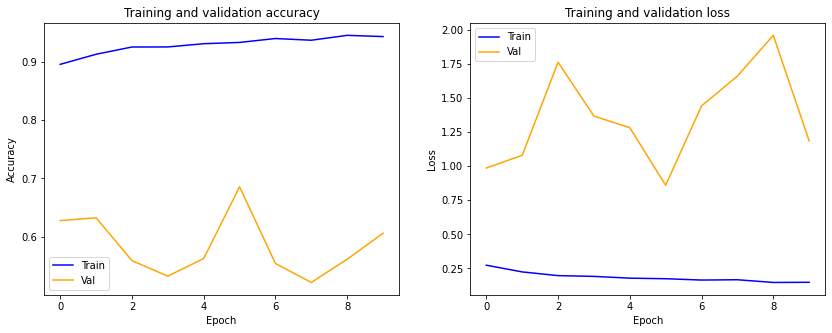

In [11]:
mdl_9_3_wo_ft_wo_da_BN.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_wo_ft_wo_da_BN.fit(X_train,label_train, 
                batch_size=BATCH_SIZE, 
                validation_data =(X_valid, label_valid),  epochs=10))

In [12]:
#save_weights
mdl_9_3_wo_ft_wo_da_BN.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da_BN.h5/"))

del mdl_9_3_wo_ft_wo_da_BN

### Version 2.b: Dropout <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation 
#### **Also** added Dropout and extra dense layer

Added only Dropout
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1024)         23900960    input_7[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 1024)         23900960    input_8[0][0]                    
_________________________________________________________________________

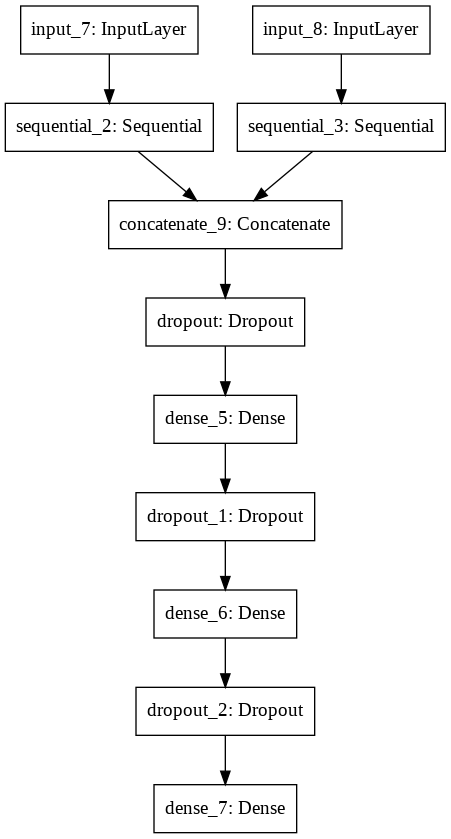

In [13]:
mdl_9_3_wo_ft_wo_da_Dropout = create_model_keras_inputs_two_updated(fine_tune = False, add_BN = False, add_Dropout = True)
mdl_9_3_wo_ft_wo_da_Dropout.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da_Dropout))

Epoch 1/10
299/299 [==============================] - 37s 96ms/step - loss: 1.7477 - accuracy: 0.7888 - val_loss: 0.6846 - val_accuracy: 0.6181
Epoch 2/10
299/299 [==============================] - 27s 89ms/step - loss: 0.3224 - accuracy: 0.8792 - val_loss: 0.6669 - val_accuracy: 0.6060
Epoch 3/10
299/299 [==============================] - 27s 89ms/step - loss: 0.3086 - accuracy: 0.8838 - val_loss: 0.7885 - val_accuracy: 0.6398
Epoch 4/10
299/299 [==============================] - 27s 89ms/step - loss: 0.2843 - accuracy: 0.8957 - val_loss: 0.8653 - val_accuracy: 0.5952
Epoch 5/10
299/299 [==============================] - 27s 89ms/step - loss: 0.2719 - accuracy: 0.8953 - val_loss: 0.8113 - val_accuracy: 0.6241
Epoch 6/10
299/299 [==============================] - 27s 89ms/step - loss: 0.2571 - accuracy: 0.9082 - val_loss: 0.8447 - val_accuracy: 0.6157
Epoch 7/10
299/299 [==============================] - 27s 89ms/step - loss: 0.2568 - accuracy: 0.9035 - val_loss: 1.1055 - val_accuracy:

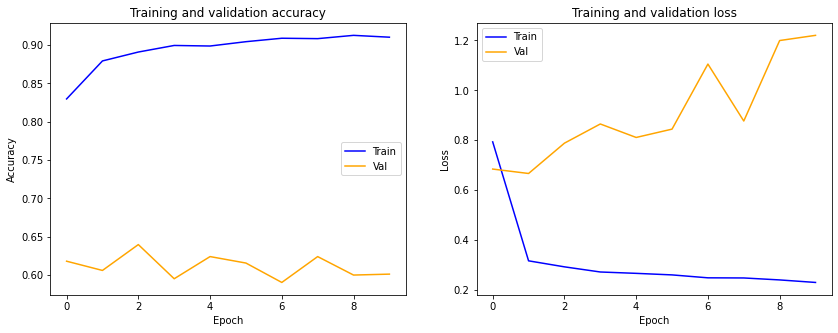

In [14]:
mdl_9_3_wo_ft_wo_da_Dropout.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['accuracy'])


plot(mdl_9_3_wo_ft_wo_da_Dropout.fit(X_train,label_train, 
                batch_size=BATCH_SIZE, 
                validation_data =(X_valid, label_valid),  epochs=10))

In [15]:
#save_weights
mdl_9_3_wo_ft_wo_da_Dropout.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da_Dropout.h5/"))

del mdl_9_3_wo_ft_wo_da_Dropout

### Version 2.c: Batch Norm + Dropout <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation 
#### **Also** added Batch Normailzation, Dropout, and extra dense layer

Added BN and Dropout
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 1024)         23900960    input_11[0][0]                   
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 1024)         23900960    input_12[0][0]                   
_______________________________________________________________________

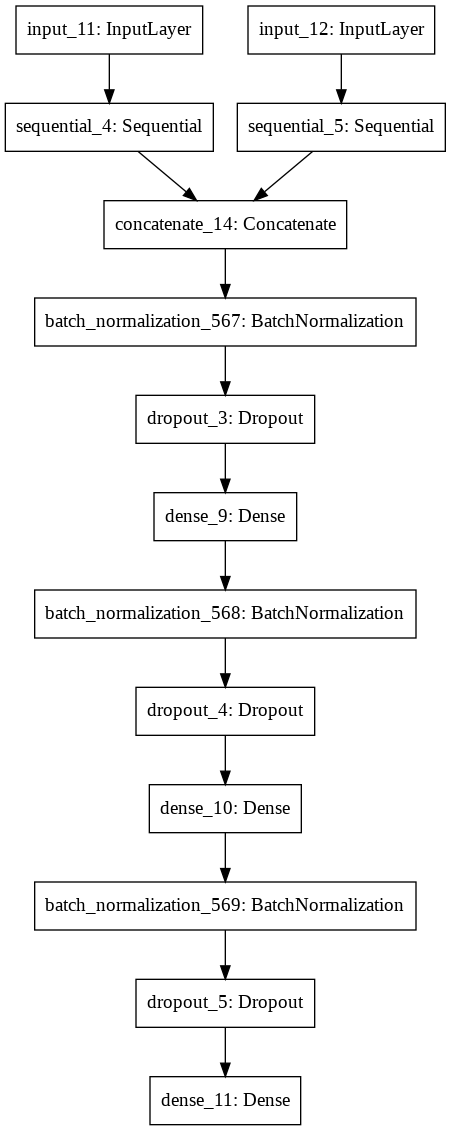

In [16]:
mdl_9_3_wo_ft_wo_da_BN_DO = create_model_keras_inputs_two_updated(fine_tune = False, add_BN = True, add_Dropout = True)
mdl_9_3_wo_ft_wo_da_BN_DO.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da_BN_DO))

Epoch 1/10
299/299 [==============================] - 38s 99ms/step - loss: 0.3780 - accuracy: 0.8576 - val_loss: 1.1864 - val_accuracy: 0.5855
Epoch 2/10
299/299 [==============================] - 27s 90ms/step - loss: 0.2669 - accuracy: 0.8960 - val_loss: 1.0768 - val_accuracy: 0.6277
Epoch 3/10
299/299 [==============================] - 27s 90ms/step - loss: 0.2342 - accuracy: 0.9130 - val_loss: 1.1031 - val_accuracy: 0.6084
Epoch 4/10
299/299 [==============================] - 27s 90ms/step - loss: 0.2215 - accuracy: 0.9147 - val_loss: 1.2574 - val_accuracy: 0.6133
Epoch 5/10
299/299 [==============================] - 27s 90ms/step - loss: 0.2004 - accuracy: 0.9224 - val_loss: 1.2081 - val_accuracy: 0.5988
Epoch 6/10
299/299 [==============================] - 27s 90ms/step - loss: 0.1995 - accuracy: 0.9250 - val_loss: 1.0925 - val_accuracy: 0.6060
Epoch 7/10
299/299 [==============================] - 27s 90ms/step - loss: 0.2058 - accuracy: 0.9203 - val_loss: 1.1269 - val_accuracy:

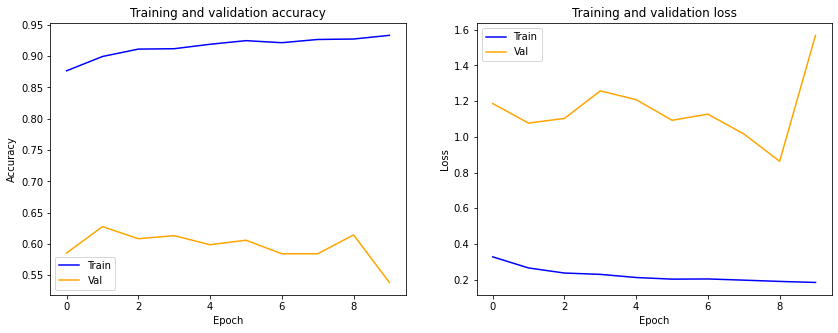

In [17]:
mdl_9_3_wo_ft_wo_da_BN_DO.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['accuracy'])


plot(mdl_9_3_wo_ft_wo_da_BN_DO.fit(X_train,label_train, 
                batch_size=BATCH_SIZE, 
                validation_data =(X_valid, label_valid),  epochs=10))

In [18]:
#save_weights
mdl_9_3_wo_ft_wo_da_BN_DO.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da_BN_DO.h5/"))

del mdl_9_3_wo_ft_wo_da_BN_DO